###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch


from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP
from micrograd.onehot import arr2vals, oh_encode
from micrograd.eval import evaluate, calc_accuracy, calc_sq_loss, feed_forward

%matplotlib inline

In [2]:
np.random.seed(1337)
random.seed(1337)

# Get MNIST dataset

In [3]:
from torchvision import datasets as dts

MNIST_DATASET = dts.MNIST(root = 'data', train = True, download=True)

X_train = MNIST_DATASET.data / 255.0 # * 2 - 1
X_train = X_train.reshape(X_train.shape[0], 784)

Y_train = MNIST_DATASET.targets

In [4]:
ALL_POSITIVE_CLASSES = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

enc, dec = oh_encode(ALL_POSITIVE_CLASSES)
enc(ALL_POSITIVE_CLASSES)

tensor([[ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1.,  1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.]])

In [5]:
import torch


def append_noise(X, noise_size, min=-1.0, max=1.0):
    noise_shape = torch.Size([noise_size]) + X.shape[1:]
    noise_tensor = torch.empty(noise_shape).uniform_(min, max)
    return torch.concat([X, noise_tensor])


def append_void(X, void_size, void=-1.0):
    void_shape = torch.Size([void_size]) + X.shape[1:]
    void_tensor = torch.empty(void_shape).fill_(void)
    return torch.concat([X, void_tensor])


def get_batch(X, Y, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=-1):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y = X[ri], Y[ri]

    if noise_ratio > 0.0:
        noise_size = round(batch_size * noise_ratio)
        X = append_noise(X, noise_size)
        Y = torch.concat([Y, torch.tensor([void_class] * noise_size)])

    if void_ratio > 0.0:
        void_size = round(batch_size * void_ratio)
        X = append_void(X, void_size, void=np.random.uniform(0, 1))
        Y = torch.concat([Y, torch.tensor([void_class] * void_size)])

    return X, Y


def batch2vals(batch):
    return tuple(map(arr2vals, batch))


# save/load

In [6]:
POSITIVE_NEURONS = 'mnist_parameters_10x785_positives.npy'


def save_neurons(file, neurons):
    weights = np.array([[p.data for p in n.parameters()] for n in neurons])
    np.save(file, weights)


def load_neurons(file):
    weights = np.load(file)
    neurons = [Neuron(nin=weights.shape[1] - 1, act='sbin') for _ in range(weights.shape[0])]
    for Wi in range(len(neurons)):
        for p, w in zip(neurons[Wi].parameters(), weights[Wi]):
            p.data = w
            p._lr = 0.0
    return neurons

In [7]:
import matplotlib.pyplot as plt


def select(X, Y, selector):
    idx = np.where(np.isin(Y, selector))[0]
    return X[idx], Y[idx]


def select_batch(X, Y, selector, batch_size, noise_ratio=0.0, void_ratio=0.0, void_class=torch.nan):
    idx = np.where(np.isin(Y, selector))[0]
    return get_batch(X[idx], Y[idx], batch_size, noise_ratio, void_ratio, void_class)


def draw_neuron(model, neuron, layer=0):
    w = np.array([p.data for p in model.layers[layer].neurons[neuron].parameters()][:-1])
    w = w.reshape([-1, w.shape[0]])
    plt.imshow(w)


def one_neuron_histo(neuron, bins=100):
    array = np.array([p.data for p in neuron.parameters()])
    plt.hist(array, bins=bins, edgecolor='black')

    plt.title('Гистограмма нейрона')
    plt.xlabel('Вес')
    plt.ylabel('Частота')

    plt.show()


def draw_all_neurons(neurons):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([p.data for p in neuron.parameters()][:28**2])
        array = array.reshape([-1, array.shape[0]])
        axe.imshow(array.reshape([28, 28]))
    fig.suptitle("Нейроны")


def all_neurons_histo(neurons, bins=100):
    fig, axes = plt.subplots(1, len(neurons), sharey=True)
    if len(neurons) == 1:
        axes = [axes]

    for neuron, axe in zip(neurons, axes):
        array = np.array([p.data for p in neuron.parameters()])
        axe.hist(array, bins=bins, edgecolor='black')

    fig.suptitle('Гистограмма нейронов')
    fig.supxlabel('Вес')
    fig.supylabel('Частота')

    plt.show()

In [8]:
import math


def fit(model, X, Y_oh, oh_decoder, iterations, q=0.75, esat=1e-9):
    total_loss, acc, scores, targets = evaluate(model, X, Y_oh, oh_decoder)
    print(f"start: loss {total_loss.data}, accuracy {acc*100}%")

    for k in range(iterations):
        if total_loss.data == 0:
            print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")
            return total_loss.data, acc, scores, targets

        model.learn_from(total_loss, q)

        total_loss, acc, scores, targets = evaluate(model, X, Y_oh, oh_decoder)
        print(f"step {k}: loss {total_loss.data}, accuracy {acc*100}%")

        if total_loss.data <= esat:
            print(f"Early STOP!")
            break

    return total_loss, acc, scores, targets



def get_model_for(classes, batch, iterations, model=None, q=0.75, esat=1e-9, with_frozen_neurons=False):
    X, Y = batch
    DIM = len(classes)
    LAYER_0_SIZE = math.comb(DIM, 2) + (DIM if not with_frozen_neurons else 0)

    oh_encoder, oh_decoder = oh_encode(classes)
    oh_decoder([Value(0)] * DIM)

    Y_oh = oh_encoder(Y)

    # initialize a model
    if model is None:
        model = MLP(
            [
                # Layer([784, LAYER_0_SIZE], 'minmax', lr=1.0),
                # Layer([LAYER_0_SIZE, DIM], 'sbin', lr=1.0)
                Layer([784, DIM], 'sbin', lr=1.0, _lid=0)
            ]
        )
        model.norm()

    if with_frozen_neurons:
        frozen_positives = [n for c, n in enumerate(load_neurons(POSITIVE_NEURONS)) if c in classes]
        model.layers[0].neurons = model.layers[0].neurons + frozen_positives

    total_loss, acc, scores, targets = fit(model, X, Y_oh, oh_decoder, iterations, esat=esat, q=q)

    return (model, total_loss, acc), (scores, targets), (oh_encoder, oh_decoder)

start: loss 28.0, accuracy 10.0%
step 0: loss 8.0, accuracy 70.0%


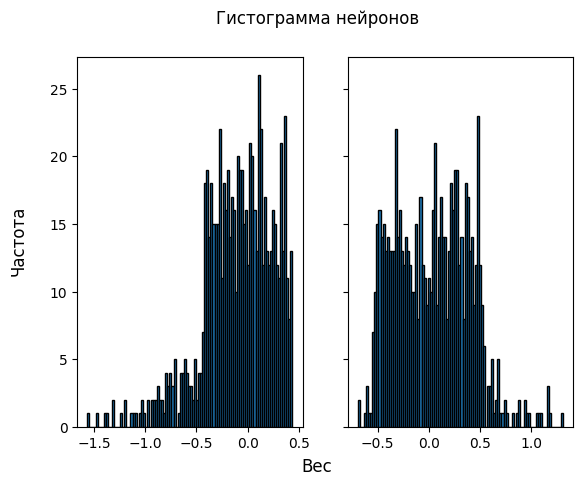

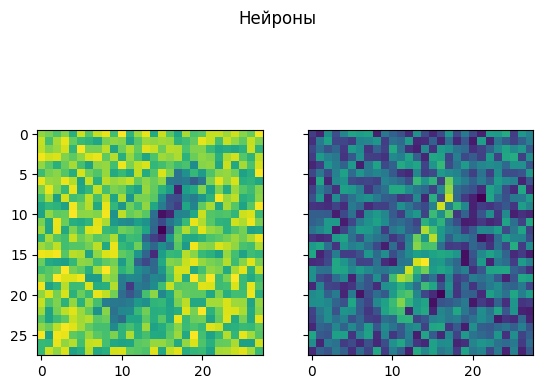

In [9]:
SELECTED_CLASSES = [0, 1]
NOISE_RATIO = 0.0
VOID_RATIO = 0.0
ITERATIONS = 1
BATCH_SIZE = 10
BATCH = select_batch(X_train, Y_train, SELECTED_CLASSES, BATCH_SIZE, noise_ratio=NOISE_RATIO, void_ratio=VOID_RATIO)
X, Y = BATCH

(model, total_loss, accuracy), (scores, targets), (oh_encoder, oh_decoder) = get_model_for(SELECTED_CLASSES, BATCH, ITERATIONS, q=1.0)
all_neurons_histo(model.layers[0].neurons)
draw_all_neurons(model.layers[0].neurons)

# DEBUG

In [10]:
total_loss.backward()
model.layers[0].neurons[0].parameters()

[Value(L0:n0:w0 : [0.10282565912263644, 0.0, 1.0]),
 Value(L0:n0:w1 : [0.02904859058694853, 0.0, 1.0]),
 Value(L0:n0:w2 : [-0.11714561531403947, 0.0, 1.0]),
 Value(L0:n0:w3 : [0.07491233281094316, 0.0, 1.0]),
 Value(L0:n0:w4 : [-0.29193283541262527, 0.0, 1.0]),
 Value(L0:n0:w5 : [0.28325380115068105, 0.0, 1.0]),
 Value(L0:n0:w6 : [-0.1015527777127772, 0.0, 1.0]),
 Value(L0:n0:w7 : [0.2528994232776646, 0.0, 1.0]),
 Value(L0:n0:w8 : [0.368265428731327, 0.0, 1.0]),
 Value(L0:n0:w9 : [-0.16798083873538747, 0.0, 1.0]),
 Value(L0:n0:w10 : [0.429846298427268, 0.0, 1.0]),
 Value(L0:n0:w11 : [-0.257650834116452, 0.0, 1.0]),
 Value(L0:n0:w12 : [0.13646675804558822, 0.0, 1.0]),
 Value(L0:n0:w13 : [0.36003855651550903, 0.0, 1.0]),
 Value(L0:n0:w14 : [-0.34118219363468666, 0.0, 1.0]),
 Value(L0:n0:w15 : [0.27981665450143195, 0.0, 1.0]),
 Value(L0:n0:w16 : [-0.08842438119757144, 0.0, 1.0]),
 Value(L0:n0:w17 : [-0.37955664315775417, 0.0, 1.0]),
 Value(L0:n0:w18 : [0.1739552528185464, 0.0, 1.0]),
 Val

start: loss 8.0, accuracy 70.0%
step 0: loss 8.0, accuracy 70.0%
step 1: loss 20.0, accuracy 0.0%
step 2: loss 14.0, accuracy 30.0%
step 3: loss 14.0, accuracy 30.0%
step 4: loss 2.0000000000000004, accuracy 90.0%
step 5: loss 2.0000000000000004, accuracy 90.0%
step 6: loss 3.3306690738754696e-16, accuracy 100.0%
Early STOP!


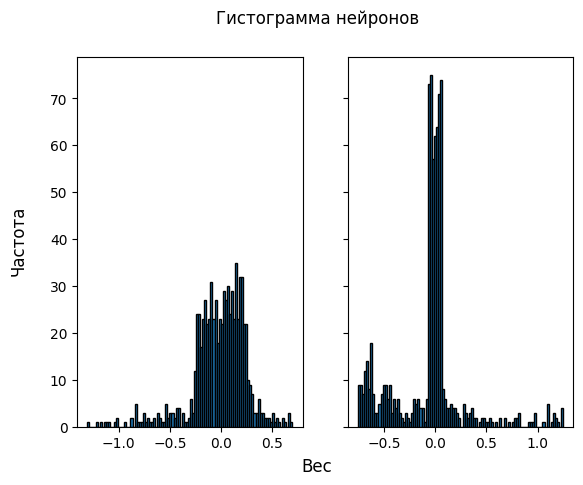

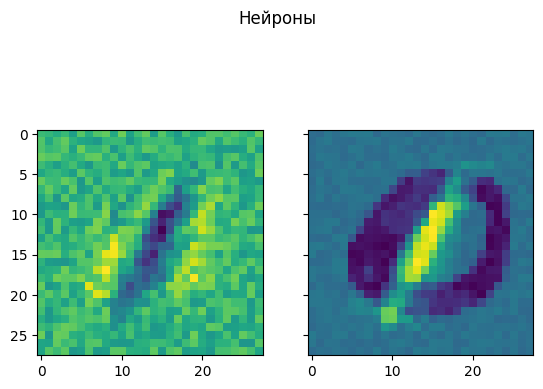

In [11]:
(model, total_loss, accuracy), (scores, targets), (oh_encoder, oh_decoder) = get_model_for(SELECTED_CLASSES, BATCH, 10, model=model, q=1.0)
all_neurons_histo(model.layers[0].neurons)
draw_all_neurons(model.layers[0].neurons)

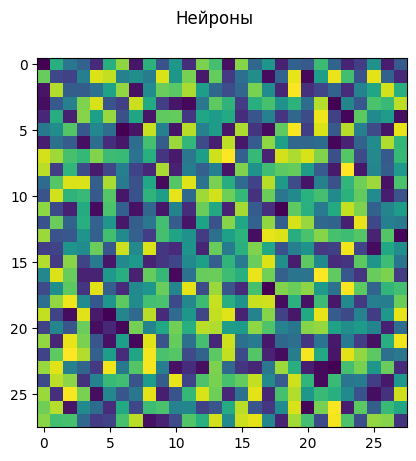

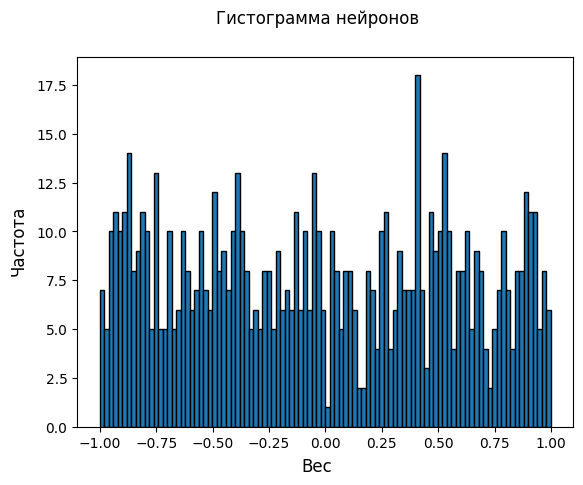

In [12]:
classes = [1, 2]

x, y = select_batch(X_train, Y_train, classes, 10, void_ratio=1.0)
oh_encoder, oh_decoder = oh_encode(classes)
y_oh = oh_encoder(y)

model = MLP(
    [
        Layer([784, 1], 'line', lr=1.0, _lid=0),
        Layer([1, len(classes)], 'sbin', init=lambda: round(random.uniform(-1,1)), bias=False, lr=1.0, _lid=1)
    ]
)
model.norm()

def loss():
    input = arr2vals(x, 'input')
    scores = feed_forward(model, input)
    targets = arr2vals(y_oh, 'target')

    total_loss = calc_sq_loss(scores, targets)
    acc = calc_accuracy(scores, targets, oh_decoder)
    return total_loss, acc * 100

NEURONS = model.layers[0].neurons
draw_all_neurons(NEURONS)
all_neurons_histo(NEURONS)

0: loss 48.0, accuracy 15.0%
final: loss 40.0, accuracy 25.0%


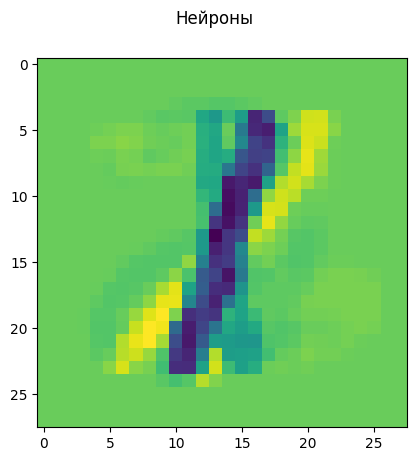

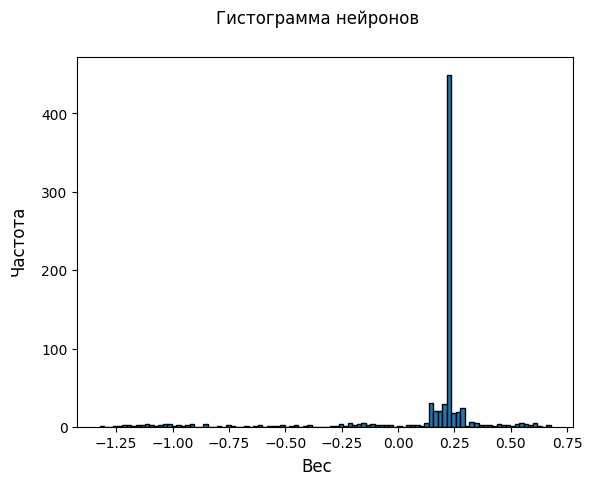

In [52]:
iterations = 1
total_loss = None

def fit(total_loss, iterations=1):
    if total_loss is None:
        total_loss, acc = loss()

    for k in range(iterations):
        print(f"{k}: loss {total_loss.data}, accuracy {acc}%")
        model.learn_from(total_loss, q=1.0)
        total_loss, acc = loss()

    return total_loss, acc

total_loss, acc = fit(total_loss, iterations)
print(f"final: loss {total_loss.data}, accuracy {acc}%")

NEURONS = model.layers[0].neurons

draw_all_neurons(NEURONS)
all_neurons_histo(NEURONS)

In [34]:
feed_forward(model, arr2vals(x, 'input'))

[[Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])],
 [Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])],
 [Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])],
 [Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])],
 [Value(sbin : [1.0, 0.0, 1.0]), Value(sbin : [1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value(sbin : [-1.0, 0.0, 1.0]), Value(sbin : [-1.0, 0.0, 1.0])],
 [Value

In [35]:
input = arr2vals(x, 'input')
scores = feed_forward(model, input)
targets = arr2vals(y_oh, 'target')

list(zip(oh_decoder(scores), oh_decoder(targets)))

[(None, 2),
 (None, 2),
 (None, 2),
 (None, 2),
 (None, 1),
 (None, 1),
 (None, 2),
 (None, 1),
 (None, 1),
 (None, 2),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None),
 (None, None)]

In [36]:
import pandas as pd

numbers = [p.data for p in model.layers[0].neurons[0].parameters()]
numbers.sort()

pd.DataFrame(numbers).describe()

,0
count,784.000000
mean,0.018265
std,0.285564
min,-0.500502
25%,-0.232385
50%,0.015187
75%,0.269027
max,0.499498
